In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc
import time

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

In [3]:
#Read Data

#Let's just read 1M rows for now
train=pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv',nrows=1000000)
test = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')

# 1. Meeting Our Data

Before we go into the problem, let's understand the data. 

<b>Features</b>
* pickup_datetime - timestamp value indicating when the taxi ride started.
* pickup_longitude - float for longitude coordinate of where the taxi ride started.
* pickup_latitude - float for latitude coordinate of where the taxi ride started.
* dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
* dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
* passenger_count - integer indicating the number of passengers in the taxi ride.

In [4]:
train.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
train.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [6]:
def checkNULLS(df, df_name):
    count = df.isnull().sum().max()
    print(f"{df_name} has {count} NULLS")

In [7]:
#Selecting only categorical data

train.select_dtypes(include="O").describe()

,key,pickup_datetime
count,1000000,1000000
unique,1000000,861755
top,2009-06-15 17:26:21.0000001,2010-02-13 19:28:00 UTC
freq,1,9


In [8]:
checkNULLS(train.select_dtypes(include="O"),"Categorical Data")

Categorical Data has 0 NULLS


In [9]:
#Visualising only numeric Data

train.select_dtypes(exclude="O").describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


Observation: 

Lattitude and Longitude should generally be in the range [-90,90] or[-180,180], here we see lot of values beyond the range.

In [10]:
checkNULLS(train.select_dtypes(include="O"),"Numerical Data")

Numerical Data has 0 NULLS


# 2. Data Cleaning

As observed, we will be cleaning up the longitude and lattitude values 

Note: 40.7128° N, 74.0060° W are the coordinates of New York City, so our values need to be around that range.

In [11]:
def plot_grid(data, fig_size, grid_size, plot_type, target = '',bins=10):
    """
    Custom function for plotting grid of plots.
    It takes: DataFrame of data, size of a grid, type of plots, string name of target variable;
    And it outputs: grid of plots.
    """
    fig = plt.figure(figsize = fig_size)
    if plot_type == 'histplot':
        for i, column_name in enumerate(data.select_dtypes(exclude = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.histplot(data[column_name], kde = True, color = 'red', stat = 'count', bins=bins)
            plot.set_xlabel(column_name, fontsize = 16)
            plot.set_ylabel('Frequency')
    if plot_type == 'boxplot':
        for i, column_name in enumerate(data.select_dtypes(exclude = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.boxplot(x = data[column_name], color = 'red')
            plot.set_xlabel(column_name, fontsize = 16)
    if plot_type == 'scatterplot':
        for i, column_name in enumerate(data.drop(target, axis = 1).select_dtypes(exclude = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.scatterplot(x = data[column_name], y = data[target], color = 'red')
            plot.set_xlabel(column_name, fontsize = 16)
            plot.set_ylabel(f"{target}")
    if plot_type == 'boxplot_cat':
        for i, column_name in enumerate(data.select_dtypes(include = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            sort = data.groupby([column_name])[target].median().sort_values(ascending = False) # This is here to make sure boxes are sorted by median
            plot = sns.boxplot(x = data[column_name], y = data[target], order = sort.index, palette = 'Reds')
            plot.set_xlabel(column_name, fontsize = 16)
            plot.set_ylabel(f"{target}")
    if plot_type == 'barplot_cat':
        for i, column_name in enumerate(data.select_dtypes(include = 'object').columns):
            fig.add_subplot(grid_size[0], grid_size[1], i + 1)
            plot = sns.barplot(x = data[column_name], y = data[target], palette = 'Reds')
            plot.set_xlabel(column_name, fontsize = 16)
    plt.tight_layout()

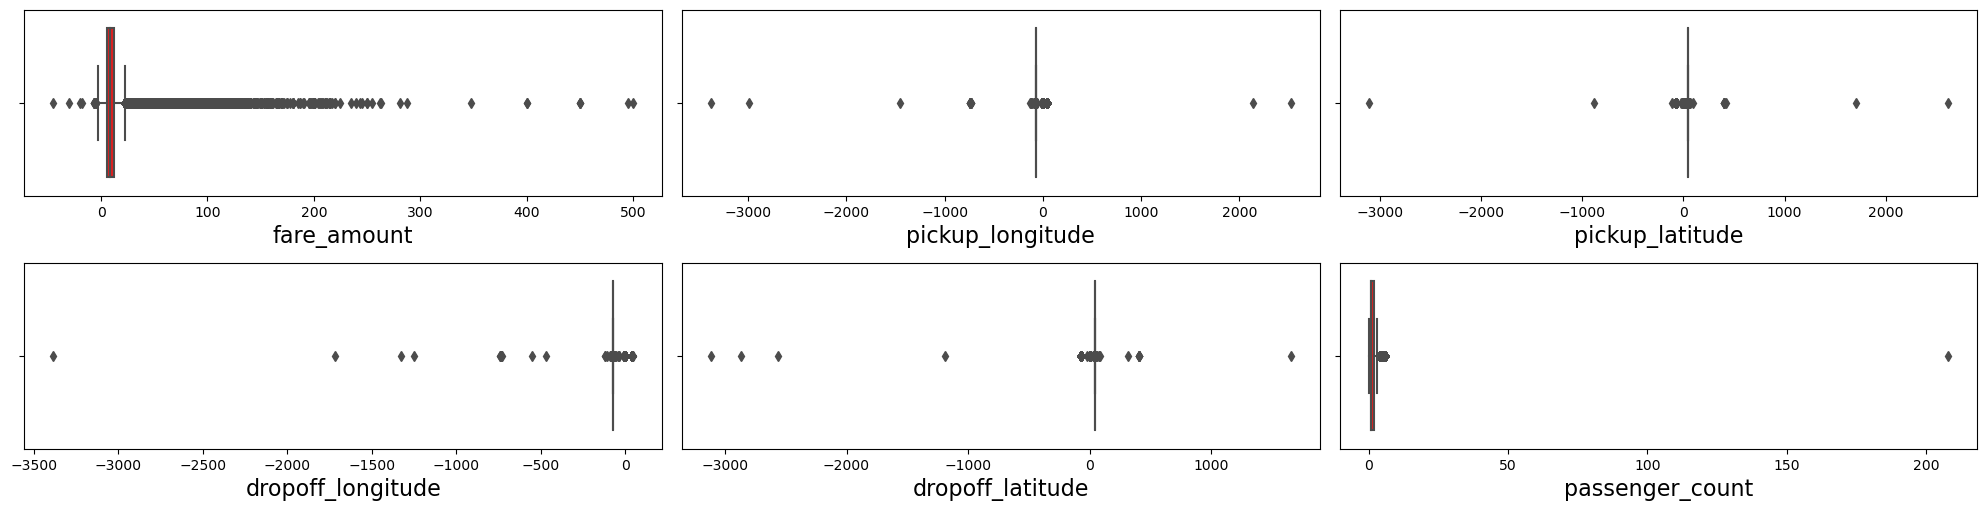

In [12]:
#Fare Price (Target) cannot be in negative, so let's look at the data before dropping them
plot_grid(train,fig_size=(20,30), grid_size=(12,3), plot_type='boxplot')

In [13]:
#Checking Lattitude and Longitude for Valid values

print('Number of observations out of valid range in coordinate columns:', end="\n")

print('pickup_longitude', end=': ')
print((train.pickup_longitude <-180).sum()+(train.pickup_longitude > 180).sum())

print('pickup_latitude', end=': ')
print((train.pickup_latitude <-90).sum()+(train.pickup_latitude > 90).sum())

print('dropoff_longitude', end=': ')
print((train.dropoff_longitude <-180).sum()+(train.dropoff_longitude > 180).sum())

print('dropoff_latitude', end=': ')
print((train.dropoff_latitude <-90).sum()+(train.dropoff_latitude > 90).sum())

print('fare_amount', end=': ')
print((train.fare_amount <=0).sum()+(train.fare_amount > 300).sum())

print('passenger_count', end=': ')
print((train.passenger_count <1).sum()+(train.passenger_count > 6).sum())

Number of observations out of valid range in coordinate columns:
pickup_longitude: 15
pickup_latitude: 12
dropoff_longitude: 13
dropoff_latitude: 12
fare_amount: 75
passenger_count: 3566


In [14]:
# We can drop the above 

train.drop(train[(train.pickup_longitude < -80) | (train.pickup_longitude > -50)].index, axis=0, inplace=True)
train.drop(train[(train.pickup_latitude < 30) | (train.pickup_latitude > 50)].index, axis=0, inplace=True)
train.drop(train[(train.dropoff_longitude < -80) | (train.dropoff_longitude > -50)].index, axis=0, inplace=True)
train.drop(train[(train.dropoff_latitude < 30) | (train.dropoff_latitude > 50)].index, axis=0, inplace=True)
train.drop(train[(train.fare_amount <= 0) | (train.fare_amount > 500)].index, axis=0, inplace=True)
train.drop(train[(train.passenger_count < 1) | (train.passenger_count > 6)].index, axis=0, inplace=True)

In [15]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,975974.000000,975974.000000,975974.000000,975974.000000,975974.000000,975974.000000
mean,11.342688,-73.975172,40.750967,-73.974235,40.751297,1.690984
std,9.758387,0.048963,0.036708,0.052692,0.040137,1.306097
min,0.010000,-78.725186,36.527530,-78.725186,34.534842,1.000000
25%,6.000000,-73.992273,40.736563,-73.991573,40.735569,1.000000
50%,8.500000,-73.982082,40.753405,-73.980590,40.753868,1.000000
75%,12.500000,-73.968308,40.767578,-73.965311,40.768417,2.000000
max,500.000000,-62.830506,47.267397,-56.311580,49.255650,6.000000


## 3.1 Feature Engineering

### 3.1.1 Travel Vectors

To calculate the absolute distance between longitudes and latitudes

In [16]:
#Let's add the absolute distance features

def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    
add_travel_vector_features(train)

### 3.1.2 Travel Distance (in KMs)

In [17]:
def haversine_np(lon1, lat1, lon2, lat2):
    
    """Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length."""
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

train['trip_distance'] = haversine_np(train['pickup_longitude'], train['pickup_latitude'], train['dropoff_longitude'], train['dropoff_latitude'])

### 3.1.3 Extract Information From DateTime Column

We can extract important temporal features from datetime columns in a dataset.

In [18]:
# helper function to extract useful info from any datetime column for ML
def extract_from_date(df):
    import datetime
    for col in df.columns:
        if 'date' in col:
            if isinstance(df[col].iloc[0], pd.Timestamp):
                df['year'] = df[col].dt.year
                df['month'] = df[col].dt.month
                df['day'] = df[col].dt.day
                df['day_of_week']=df[col].dt.dayofweek
                df['week_of_year'] = df[col].dt.isocalendar().week
                df['week_of_year'] = df['week_of_year'].astype(int)
                df['hour'] = df[col].dt.hour
            else:
                df[col] = pd.to_datetime(df[col])-datetime.timedelta(hours=4)  #adjusting for the timezone
                df[col] = df[col].dt.tz_localize(None)
                df['year'] = df[col].dt.year
                df['month'] = df[col].dt.month
                df['day'] = df[col].dt.day
                df['day_of_week']=df[col].dt.dayofweek
                df['week_of_year'] = df[col].dt.isocalendar().week
                df['week_of_year'] = df['week_of_year'].astype(int)
                df['hour'] = df[col].dt.hour;
                
extract_from_date(train)

### 3.1.4 Landmark Proximity

In [19]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude']);
    
    
for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
    add_landmark_dropoff_distance(train, name, lonlat)

In [20]:
new_features = ['abs_diff_longitude','abs_diff_latitude','trip_distance','year','month','day','day_of_week',
               'week_of_year','hour','jfk_drop_distance','lga_drop_distance','ewr_drop_distance',
               'met_drop_distance','wtc_drop_distance']

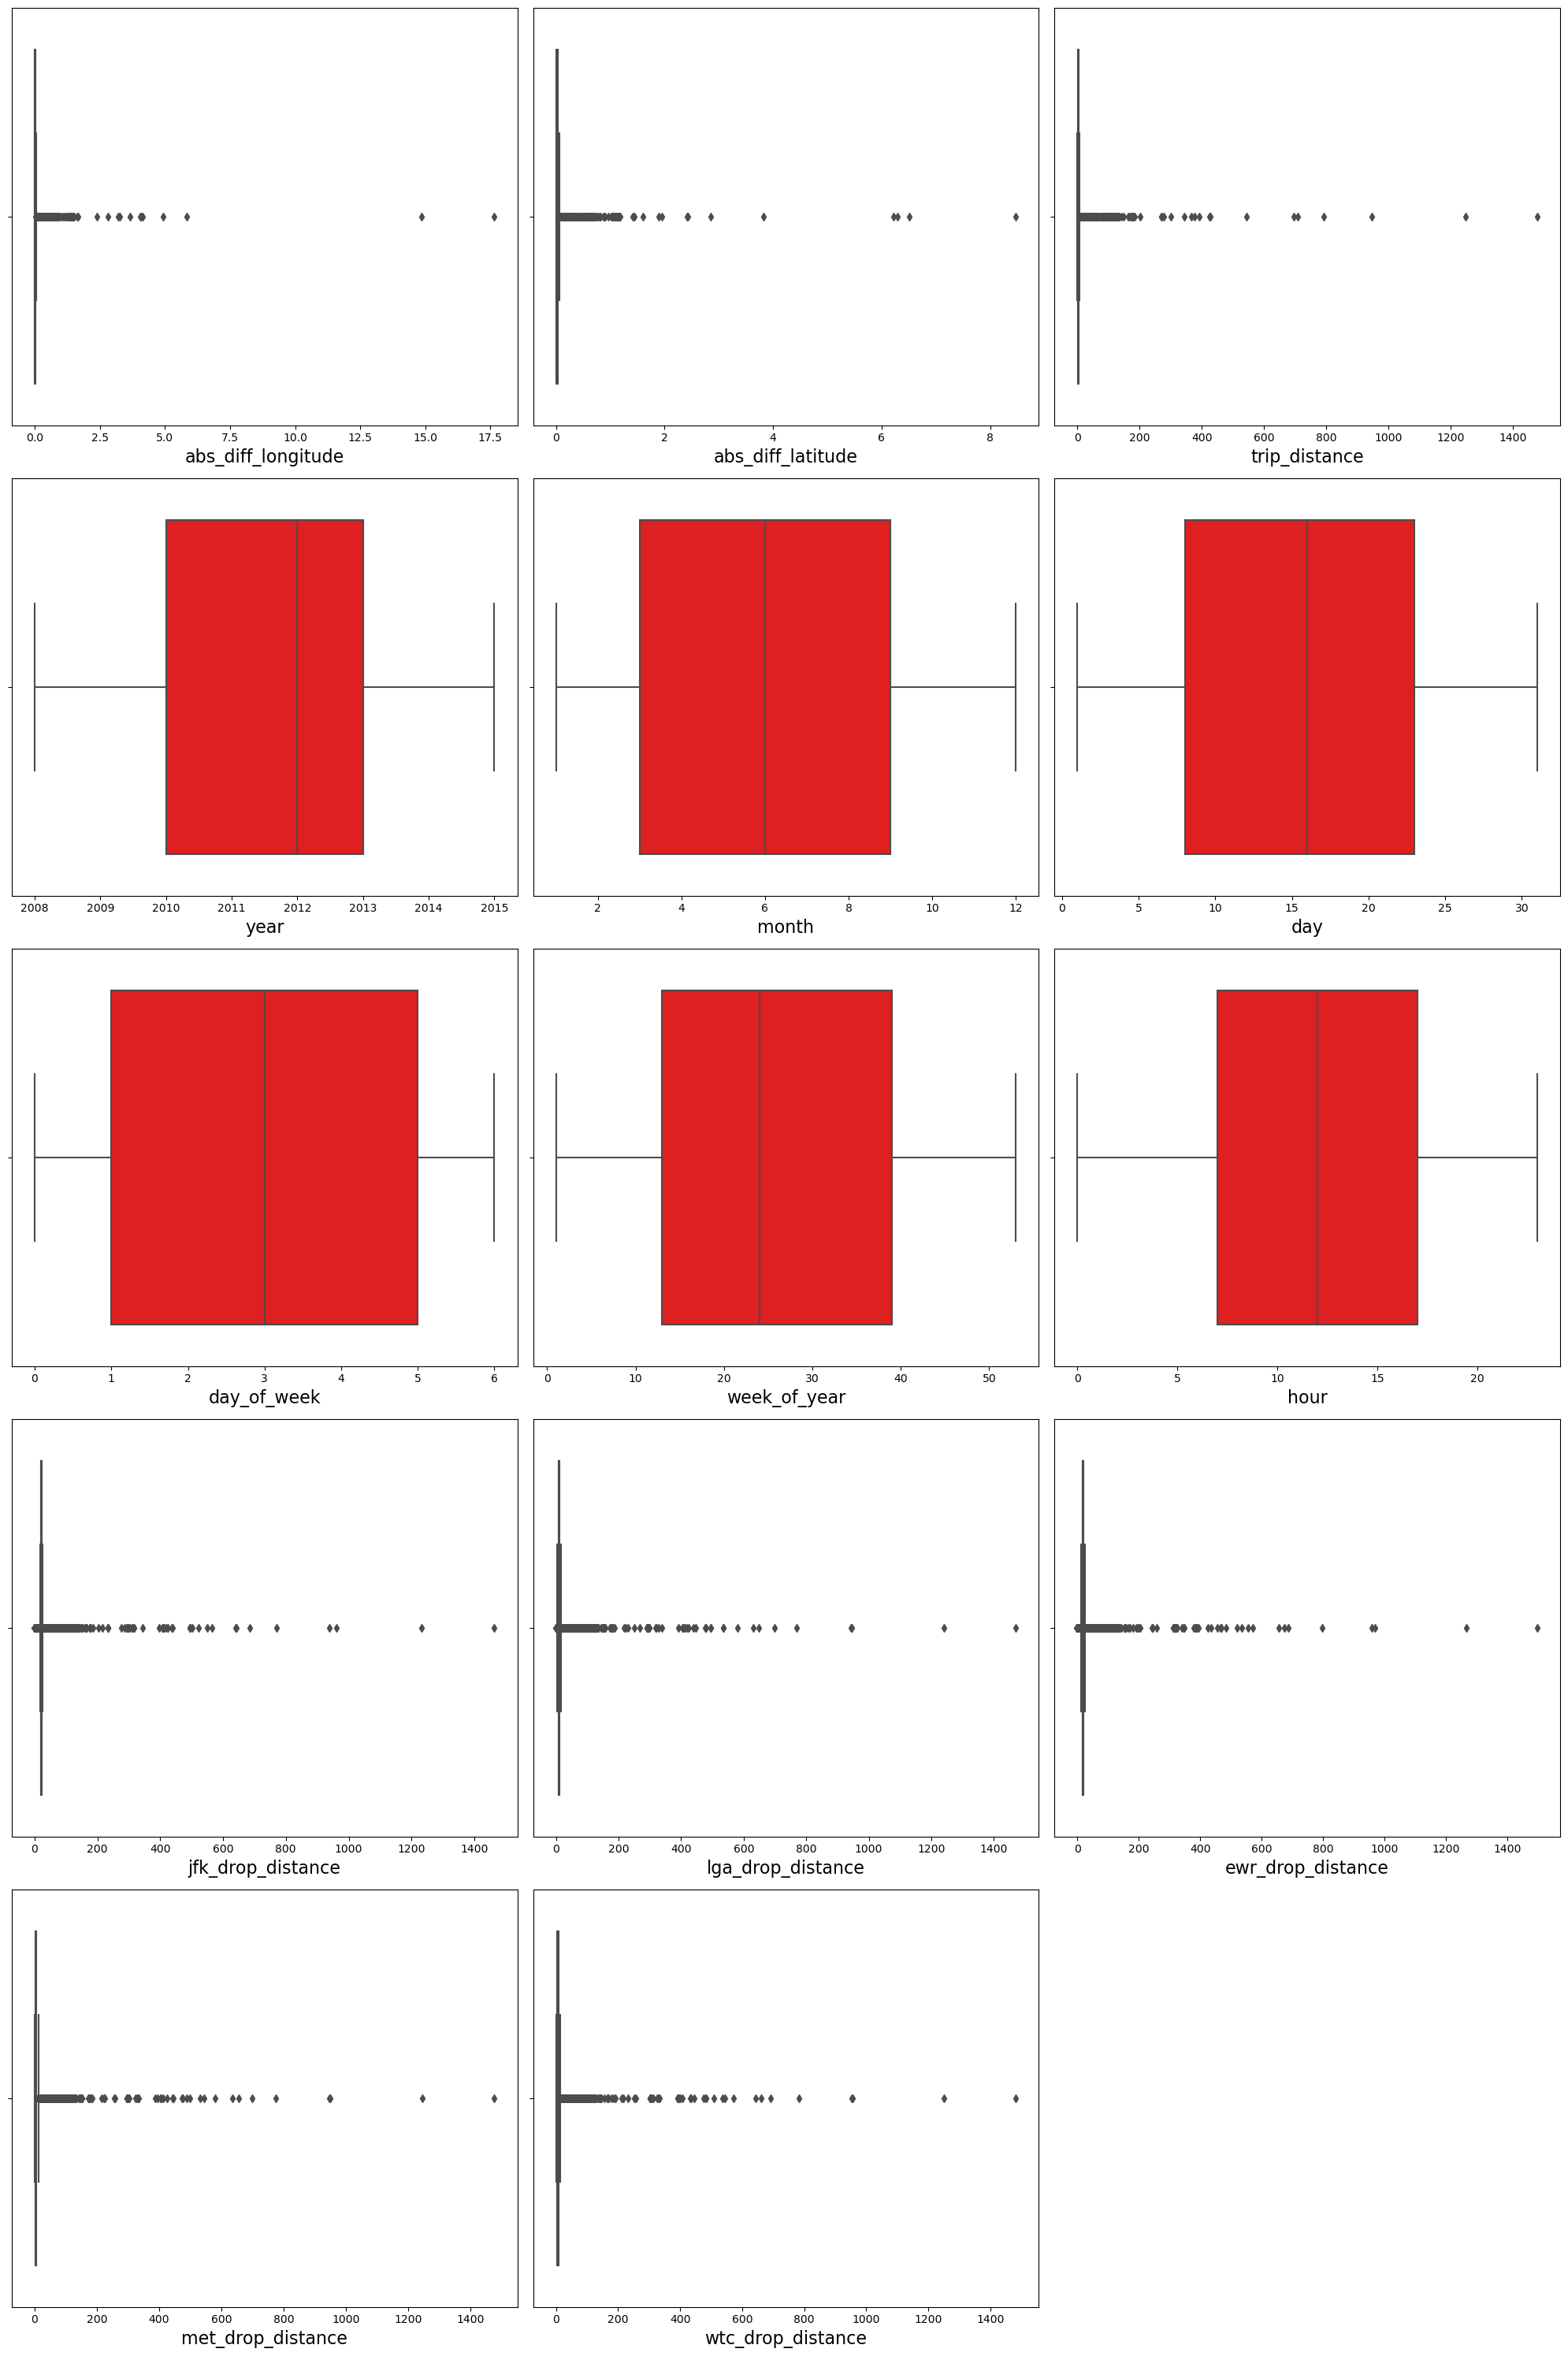

In [21]:
plot_grid(train[new_features],fig_size=(20,30), grid_size=(5,3), plot_type='boxplot')

In [22]:
train.drop(train[(train.abs_diff_longitude> 2) 
                 | (train.abs_diff_latitude > 1.5)
                 | (train.trip_distance > 500)
                 | (train.jfk_drop_distance >600)
                 | (train.lga_drop_distance > 800)
                 | (train.ewr_drop_distance > 600)
                 | (train.met_drop_distance > 800)
                 | (train.wtc_drop_distance > 600)
                ].index, axis=0, inplace=True)

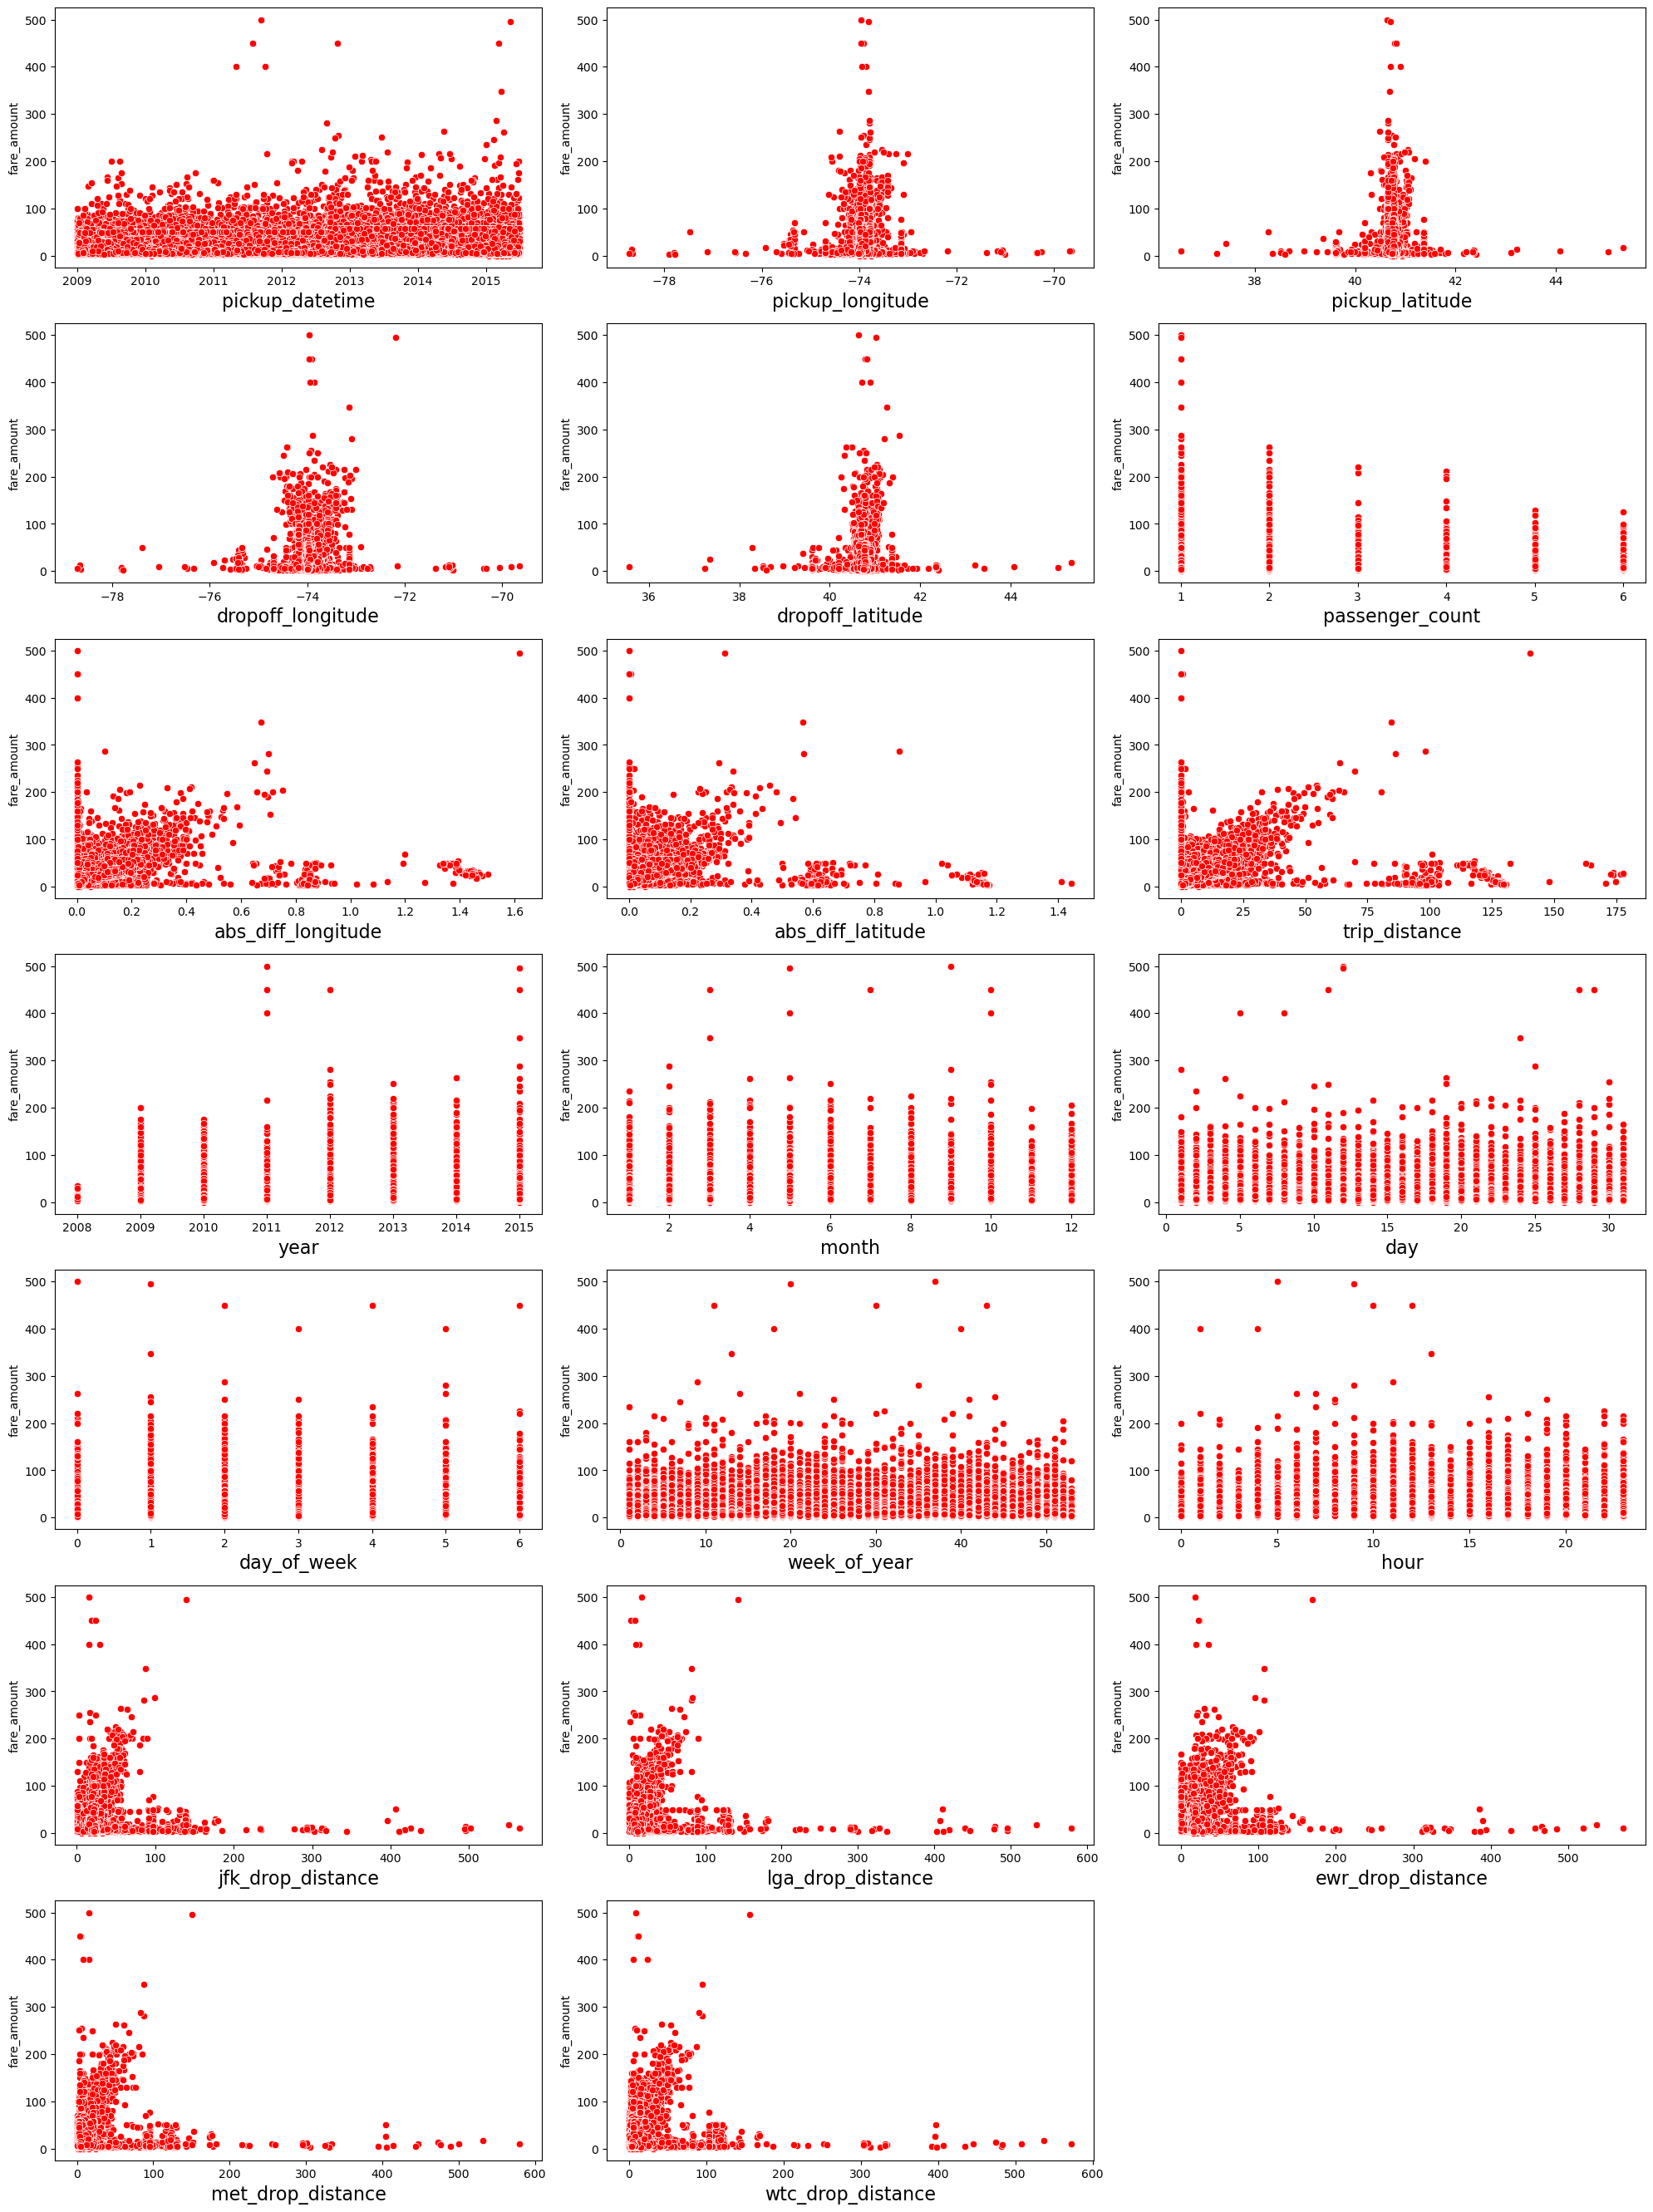

In [23]:
plot_grid(train,fig_size=(20,30), grid_size=(8,3), plot_type='scatterplot', target='fare_amount')

In [24]:
#Repeat for Test Data

#Add the new features
add_travel_vector_features(test)
test['trip_distance'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'], test['dropoff_longitude'], test['dropoff_latitude'])
extract_from_date(test)
for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
    add_landmark_dropoff_distance(test, name, lonlat)

# 4. Exploratory Data Analysis

## 4.1 Distribution of Target Variable (Fare Amount)

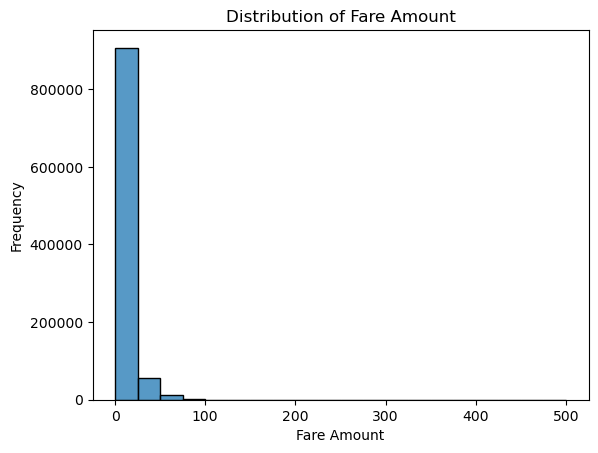

In [25]:
sns.histplot(train['fare_amount'], bins=20)
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Amount')
plt.show()

## 4.2 Scatter plot of Lattitude and Longitude 

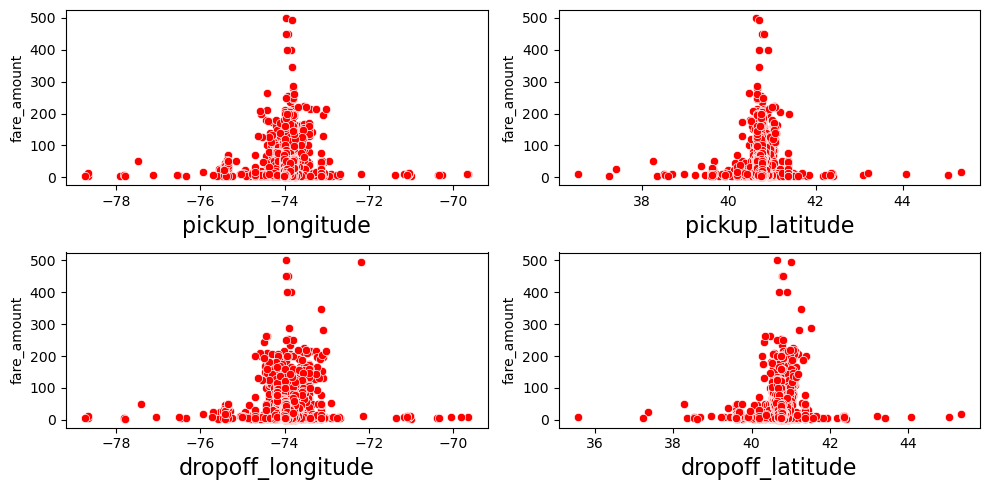

In [26]:
lat_lon=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','fare_amount']

plot_grid(train[lat_lon],fig_size=(10,5), grid_size=(2,2), plot_type='scatterplot', target='fare_amount')


Visualising spacial distribution of Longitude and Latitude

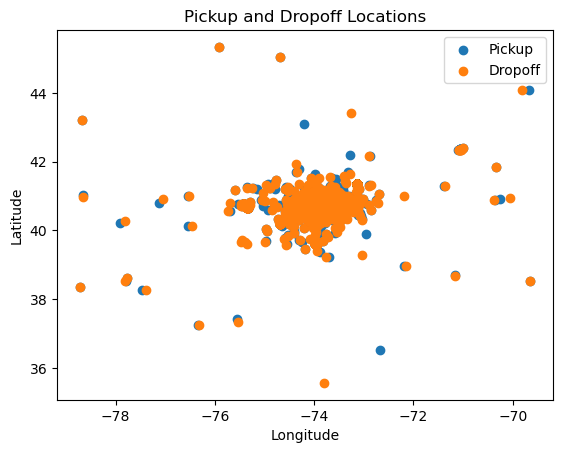

In [27]:
plt.scatter(train['pickup_longitude'], train['pickup_latitude'], label='Pickup')
plt.scatter(train['dropoff_longitude'], train['dropoff_latitude'], label='Dropoff')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup and Dropoff Locations')
plt.legend()
plt.show()

## 4.3 Distribution of Passenger Counts

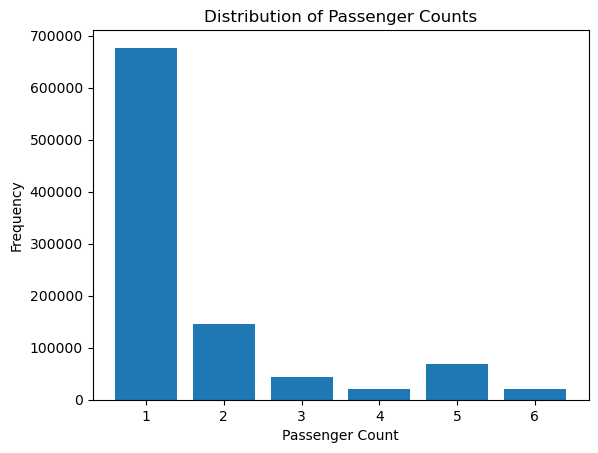

In [28]:
passenger_counts = train['passenger_count'].value_counts()
plt.bar(passenger_counts.index, passenger_counts.values)
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.title('Distribution of Passenger Counts')
plt.show()

## 4.4 Fare Price Over Time

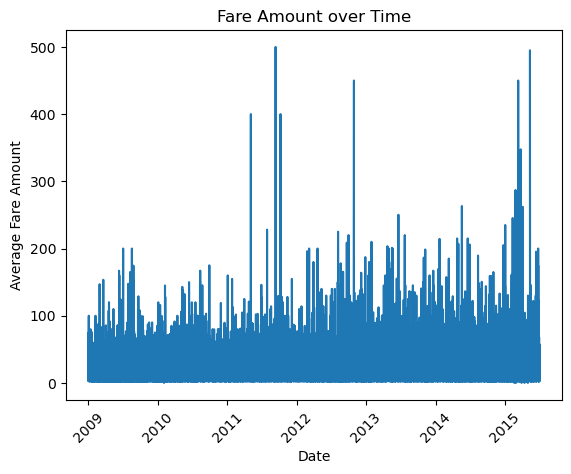

In [29]:
fare_over_time = train.groupby('pickup_datetime')['fare_amount'].mean()

plt.plot(fare_over_time.index, fare_over_time.values)
plt.xlabel('Date')
plt.ylabel('Average Fare Amount')
plt.title('Fare Amount over Time')
plt.xticks(rotation=45)
plt.show()

In [30]:
#Helper function to plot seasonal plot
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

<Axes: title={'center': 'Seasonal Plot (month/year)'}, xlabel='year', ylabel='fare_amount'>

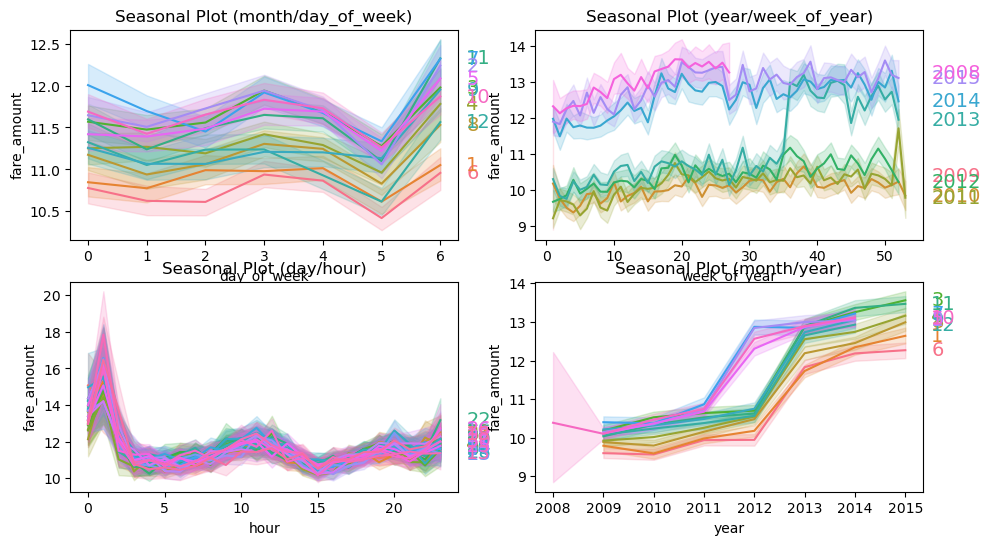

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(11, 6))
seasonal_plot(train, y="fare_amount", period="month", freq="day_of_week", ax=axs[0,0])
seasonal_plot(train, y="fare_amount", period="year", freq="week_of_year", ax=axs[0,1])
seasonal_plot(train, y="fare_amount", period="day", freq="hour", ax=axs[1,0])
seasonal_plot(train, y="fare_amount", period="month", freq="year", ax=axs[1,1])

# 5. Data Modelling

In [32]:
target = train.fare_amount

In [33]:
train.drop("key",axis=1,inplace=True)
train.drop("fare_amount",axis=1,inplace=True)
train.drop("pickup_datetime",axis=1,inplace=True)

In [34]:
#Repeat for Test

test.drop("key",axis=1,inplace=True)
test.drop("pickup_datetime",axis=1,inplace=True)

In [35]:
print("The final list of columns is : ")
display(train.columns.values)

The final list of columns is : 


array(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'abs_diff_longitude',
       'abs_diff_latitude', 'trip_distance', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'hour', 'jfk_drop_distance',
       'lga_drop_distance', 'ewr_drop_distance', 'met_drop_distance',
       'wtc_drop_distance'], dtype=object)

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, 
                                                    test_size=0.2, random_state=0)
X_test = test

In [37]:
#Evaluation Metric is RMSE
baseline_scores = pd.DataFrame(columns = ['Model Name', 'Train RMSE','Val RMSE'])

def rmse(model_name, model):
    model.fit(X_train, y_train)
    train_preds=model.predict(X_train)
    val_preds=model.predict(X_valid)
    train_rmse = mean_squared_error(y_train, train_preds, squared=False)
    val_rmse = mean_squared_error(y_valid, val_preds, squared=False)
    
    i=len(baseline_scores)
    baseline_scores.loc[i,'Model Name']=model_name
    baseline_scores.loc[i,'Train RMSE']=train_rmse
    baseline_scores.loc[i,'Val RMSE']=val_rmse

## 5.1 Baseline Models

In [38]:
models = [
    ('lr',LinearRegression()),
    ('ridge', Ridge(random_state=42)),
    ('xgb', XGBRegressor(random_state=42, 
                         n_jobs=-1, objective='reg:squarederror'))
]

for (label, model) in models:
    rmse(label, model)
    
display(baseline_scores.sort_values(by='Val RMSE').style.background_gradient(cmap='summer_r'))

print("Baseline Validation done!")

,Model Name,Train RMSE,Val RMSE
2,xgb,3.197251,3.647020
1,ridge,5.665511,5.496849
0,lr,5.665483,5.497314


Baseline Validation done!


# 6. Final Submission

In [39]:
model = XGBRegressor(random_state=42, 
                         n_jobs=-1, objective='reg:squarederror')
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [40]:
preds=model.predict(X_test)

In [41]:
sample_submission=pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv')
sample_submission['fare_amount'] = preds
sample_submission.to_csv('submission.csv', index=None)

print("Your submission was successfully saved!")

Your submission was successfully saved!
